<a href="https://colab.research.google.com/github/andrejdaskalov/rec-sys-evaluation-paper/blob/main/RecPaperSystemEvaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
DATASET_DIR = "/gdrive/MyDrive/movielens_small/ml-latest-small/"
def get_dataset_path(filename: str) -> str:
    return DATASET_DIR + filename

this function is used to standardize model run names and path

In [ ]:
import datetime
RESULT_PATH = "results/"
def get_results_path(model_name: str, dataset_type: str) -> str:
    current_time = datetime.datetime.now()
    datestr = "T".join(str(current_time).split(" "))
    subdir = RESULT_PATH + "_".join([model_name, dataset_type, datestr])
    return get_dataset_path(subdir + "/")

# Load and import

In [ ]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

In [ ]:
movie_data = pd.read_csv(get_dataset_path("enriched.csv"), na_filter=False)
movie_data.head()

,movieId,title,genres,tag,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline,year
0,1,Toy Story,adventure|animation|children|comedy|fantasy,pixar|pixar|fun,114709,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Pete Docter|Andrew Stanton|Joe R...,Bonnie Arnold|Ed Catmull|Ralph Guggenheim|Stev...,81.0,30000000.0,A little boy named Andy loves to be in his roo...,1995
1,2,Jumanji,adventure|children|fantasy,fantasy|magic board game|Robin Williams|game,113497,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh|Greg Taylor|Jim Strain|Greg...,Robert W. Cort|Ted Field|Larry Franco|Scott Kr...,104.0,50000000.0,"Jumanji, one of the most unique--and dangerous...",1995
2,3,Grumpier Old Men,comedy|romance,moldy|old,113228,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson|Mark Steven Johnson,Richard C. Berman|John Davis|George Folsey Jr....,101.0,25000000.0,Things don't seem to change much in Wabasha Co...,1995
3,4,Waiting to Exhale,comedy|drama|romance,N/A,114885,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan|Terry McMillan|Ron Bass,Ron Bass|Caron K|Terry McMillan|Deborah Schind...,124.0,16000000.0,This story based on the best selling novel by ...,1995
4,5,Father of the Bride Part II,comedy,pregnancy|remake,113041,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett|Frances Goodrich|Nancy Meyers|C...,Carol Baum|Bruce A. Block|Julie B. Crane|Jim C...,106.0,30000000.0,"In this sequel to ""Father of the Bride"", Georg...",1995


In [ ]:
USER_COLUMN_NAME = 'userId'
CONTENT_COLUMN_NAME = 'movieId'
RATING_COLUMN_NAME = 'rating'

In [ ]:
movie_data['genres'] = movie_data['genres'].apply(lambda x: x.split("|"))
movie_data['tag'] = movie_data['tag'].apply(lambda x: x.split("|"))
movie_data['cast'] = movie_data['cast'].apply(lambda x: x.split("|"))
movie_data['writers'] = movie_data['writers'].apply(lambda x: x.split("|"))
movie_data['producers'] = movie_data['producers'].apply(lambda x: x.split("|"))
movie_data.head()

,movieId,title,genres,tag,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline,year
0,1,Toy Story,"[adventure, animation, children, comedy, fantasy]","[pixar, pixar, fun]",114709,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[John Lasseter, Pete Docter, Andrew Stanton, J...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...",81.0,30000000.0,A little boy named Andy loves to be in his roo...,1995
1,2,Jumanji,"[adventure, children, fantasy]","[fantasy, magic board game, Robin Williams, game]",113497,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[Jonathan Hensleigh, Greg Taylor, Jim Strain, ...","[Robert W. Cort, Ted Field, Larry Franco, Scot...",104.0,50000000.0,"Jumanji, one of the most unique--and dangerous...",1995
2,3,Grumpier Old Men,"[comedy, romance]","[moldy, old]",113228,"[Walter Matthau, Jack Lemmon, Sophia Loren, An...","[Mark Steven Johnson, Mark Steven Johnson]","[Richard C. Berman, John Davis, George Folsey ...",101.0,25000000.0,Things don't seem to change much in Wabasha Co...,1995
3,4,Waiting to Exhale,"[comedy, drama, romance]",[N/A],114885,"[Whitney Houston, Angela Bassett, Loretta Devi...","[Terry McMillan, Terry McMillan, Ron Bass]","[Ron Bass, Caron K, Terry McMillan, Deborah Sc...",124.0,16000000.0,This story based on the best selling novel by ...,1995
4,5,Father of the Bride Part II,[comedy],"[pregnancy, remake]",113041,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[Albert Hackett, Frances Goodrich, Nancy Meyer...","[Carol Baum, Bruce A. Block, Julie B. Crane, J...",106.0,30000000.0,"In this sequel to ""Father of the Bride"", Georg...",1995


In [ ]:
movie_data_indexed = movie_data.set_index(CONTENT_COLUMN_NAME)

# Datasets
> NOTE: use only one of below dataset preparation groups, otherwise they overwrite eachother

# Prepare Normal Interactions dataset

In [ ]:
DATASET_TYPE = "full"

In [ ]:
movie_ratings = pd.read_csv(get_dataset_path("ratings.csv"))
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
len(movie_ratings)

100836

split by timestamp

In [ ]:
INTERACTIONS_TEST_SIZE = 0.2
from math import ceil, floor
movie_ratings.sort_values('timestamp', inplace=True)
interactions_train_df = movie_ratings.groupby('userId', group_keys=False).apply(lambda x: x.head(ceil((1-INTERACTIONS_TEST_SIZE)*len(x))))
interactions_test_df = movie_ratings.groupby('userId', group_keys=False).apply(lambda x: x.tail(floor(INTERACTIONS_TEST_SIZE*len(x))))
interactions_train_df.head()

,userId,movieId,rating,timestamp
43,1,804,4.0,964980499
73,1,1210,5.0,964980499
183,1,2826,4.0,964980523
120,1,2018,5.0,964980523
171,1,2628,4.0,964980523


In [ ]:
interactions_train_df_indexed = interactions_train_df.set_index('userId')
interactions_test_df_indexed = interactions_test_df.set_index('userId')
movie_ratings_indexed = movie_ratings.set_index('userId')

# Prepare Reduced interactions dataset

In [ ]:
DATASET_TYPE = "reduced"

In [ ]:
interactions_train_df_indexed = pd.read_csv(get_dataset_path("reduced_interactions.csv"), index_col="userId")
interactions_test_df_indexed = pd.read_csv(get_dataset_path("reduced_interactions_heldout.csv"), index_col="userId")
movie_ratings_indexed = pd.concat([interactions_train_df_indexed, interactions_test_df_indexed])
movie_ratings_indexed.head()

In [ ]:
interactions_train_df = interactions_train_df_indexed.reset_index()
interactions_test_df = interactions_test_df_indexed.reset_index()
movie_ratings = movie_ratings_indexed.reset_index()

# Prepare Mixed Interactions dataset

In [ ]:
DATASET_TYPE = "mixed"

In [ ]:
interactions_train_df_indexed = pd.read_csv(get_dataset_path("mixed_interactions.csv"), index_col="userId")
interactions_test_df_indexed = pd.read_csv(get_dataset_path("mixed_interactions_heldout.csv"), index_col="userId")
movie_ratings_indexed = pd.concat([interactions_train_df_indexed, interactions_test_df_indexed])
movie_ratings_indexed.head()

,movieId,rating,timestamp
userId,,,
448,69640,3.0,1289145810
352,90866,4.5,1493674691
599,1623,2.5,1498516912
474,2583,4.0,1081177421
465,2278,4.0,959896203


In [ ]:
interactions_train_df = interactions_train_df_indexed.reset_index()
interactions_test_df = interactions_test_df_indexed.reset_index()
movie_ratings = movie_ratings_indexed.reset_index()

# Evaluation

In [ ]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id][CONTENT_COLUMN_NAME]
    # interacted_items = interactions_df
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [ ]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    def __init__(self, interactions_df_full, interactions_df_train, interactions_df_test, content_df):
        self.interactions_df_full = interactions_df_full
        self.interactions_df_train = interactions_df_train
        self.interactions_df_test = interactions_df_test
        self.content_df = content_df


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, self.interactions_df_full)
        all_items = set(self.interactions_df_full[CONTENT_COLUMN_NAME])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(list(non_interacted_items), sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index


    def _calculate_recall(self, person_interacted_items_testset, person_recs_df, person_id):
        hits_at_5_count = 0
        hits_at_10_count = 0

        interacted_items_count_testset = len(person_interacted_items_testset)
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df[CONTENT_COLUMN_NAME].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df[CONTENT_COLUMN_NAME].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items,
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        recall_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return recall_metrics


    def _calculate_precision(self, person_interacted_items_testset, person_recs_df : pd.DataFrame, person_id):

        hits_at_5_count = 0
        hits_at_10_count = 0


        top_5 = person_recs_df.head(5)
        top_10 = person_recs_df.head(10)

        top_5_filtered = top_5[top_5[CONTENT_COLUMN_NAME].isin(person_interacted_items_testset)]
        top_10_filtered = top_10[top_10[CONTENT_COLUMN_NAME].isin(person_interacted_items_testset)]

        hits_at_5_count = top_5_filtered.__len__()
        hits_at_10_count = top_10_filtered.__len__()

        precision_at_5 = hits_at_5_count / 5.0
        precision_at_10 = hits_at_10_count / 10.0


        precision_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'precision@5': precision_at_5,
                          'precision@10': precision_at_10}
        return precision_metrics


    # calculate the mean reciprocal rank (MRR)
    # Mean Reciprocal Rank (MRR) at K evaluates how quickly a ranking system can show the first relevant item in the top-K results.
    # MRR = 1/U sum_(u=1, U)(1/ rank_i)
    # where U is the total number of users and i is the position of the first relevant item for user u in top K results
    # in this method, I calculate the reciprocal rank for each user to later calculate the MRR for all users
    def _calculate_rr_user(self, person_interacted_items_testset: set[int], person_recs_df: pd.DataFrame, person_id: int):


        first_relevant_item = person_recs_df[person_recs_df[CONTENT_COLUMN_NAME]\
         .isin(person_interacted_items_testset)].head(1)

        if first_relevant_item.empty:
            return {"rr": -1 }

        idx_first_relevant_item = first_relevant_item.index[0]

        rr =  1/ int( idx_first_relevant_item + 1 )
        return {
            "rr": rr
        }



    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = self.interactions_df_test.loc[person_id]
        if type(interacted_values_testset[CONTENT_COLUMN_NAME]) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset[CONTENT_COLUMN_NAME])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset[CONTENT_COLUMN_NAME])])
        # interacted_items_count_testset = len(person_interacted_items_testset)

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id,
                                               items_to_ignore=get_items_interacted(person_id,
                                                                                    self.interactions_df_train),
                                               topn=1000, verbose=True)

        recall_metrics = self._calculate_recall(person_interacted_items_testset, person_recs_df, person_id)
        precision_metrics = self._calculate_precision(person_interacted_items_testset, person_recs_df, person_id)
        rr_metric = self._calculate_rr_user(person_interacted_items_testset, person_recs_df, person_id)

        person_metrics = {
            'recall': recall_metrics,
            'precision': precision_metrics,
            'rr': rr_metric,
        }

        return person_metrics

    def evaluate_model(self, model) -> tuple[pd.DataFrame, dict]:

        print(f'Evaluating {model.get_model_name()} recommendation model...')

        people_metrics_recall = []
        people_metrics_precision = []
        people_metrics_rr = []
        for idx, person_id in enumerate(list(self.interactions_df_test.index.unique().values)):

            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics_recall = person_metrics['recall']
            person_metrics_precision = person_metrics['precision']
            person_metrics_rr = person_metrics['rr']

            person_metrics_recall['_person_id'] = person_id
            people_metrics_recall.append(person_metrics_recall)

            person_metrics_precision['_person_id'] = person_id
            people_metrics_precision.append(person_metrics_precision)


            person_metrics_rr['_person_id'] = person_id
            people_metrics_rr.append(person_metrics_rr)
        print('%d users processed' % idx)

        detailed_results_recall_df = pd.DataFrame(people_metrics_recall) \
                            .sort_values('interacted_count', ascending=False)

        detailed_results_precision_df = pd.DataFrame(people_metrics_precision)

        detailed_results_rr_df = pd.DataFrame(people_metrics_rr)


        global_recall_at_5 = detailed_results_recall_df['hits@5_count'].sum() / float(detailed_results_recall_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_recall_df['hits@10_count'].sum() / float(detailed_results_recall_df['interacted_count'].sum())

        global_precision_at_5 = detailed_results_precision_df['hits@5_count'].sum() / float(detailed_results_precision_df.__len__() * 5)
        global_precision_at_10 = detailed_results_precision_df['hits@10_count'].sum() / float(detailed_results_precision_df.__len__() * 10)

        sum_rr = detailed_results_rr_df[detailed_results_rr_df['rr'] != -1]['rr'].sum()
        num_users = len(list(self.interactions_df_test.index.unique().values))
        mean_reciprocal_rank = (1 / int(num_users) ) * sum_rr

        global_metrics = {'modelName': [model.get_model_name()],
                          'recall@5': [global_recall_at_5],
                          'recall@10': [global_recall_at_10],
                          'precision@5': [global_precision_at_5],
                          'precision@10': [global_precision_at_10],
                          'mrr': [mean_reciprocal_rank]
                          }
        global_metrics_df = pd.DataFrame(global_metrics)
        dataframes = {'recall': detailed_results_recall_df,
                      'precision': detailed_results_precision_df,
                      'rr': detailed_results_rr_df
        }
        return global_metrics_df, dataframes

    def print_results(self, global_metrics, dataframes):
        print('\nGlobal metrics:\n%s' % global_metrics)
        for _, df in dataframes.items():
            print(df.head(50))

    def save_results(self, global_metrics: pd.DataFrame, dataframes: dict[str, pd.DataFrame], model_name, dataset_type):
        file_path = get_results_path(model_name, dataset_type)
        os.makedirs(file_path, exist_ok=True)
        global_metrics.to_csv(file_path + "global_metrics.csv")
        for key, df in dataframes.items():
            df.to_csv(file_path+key+".csv")


model_evaluator = ModelEvaluator(movie_ratings_indexed, interactions_train_df_indexed, interactions_test_df_indexed, movie_data)

# Popularity based (as a baseline)

In [ ]:
class PopularityRecommender:

    MODEL_NAME = 'Popularity'


    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        self.compute_most_popular()

    def compute_most_popular(self):
        # self.popularity_df = self.popularity_df.groupby(CONTENT_COLUMN_NAME)[RATING_COLUMN_NAME].sum().sort_values(ascending=False).reset_index()
        movie_avg_ratings = movie_ratings.groupby('movieId', as_index=False)['rating'].mean()
        movie_avg_ratings.columns = ['movieId', 'rating']
        movie_viewcount = movie_ratings.groupby(['movieId'], as_index=False).size()
        movie_viewcount.columns = ['movieId', 'views']
        self.popularity_df = movie_avg_ratings.merge(movie_viewcount,
                    how='inner',
                    left_on='movieId',
                    right_on='movieId').sort_values(['views', 'rating'], ascending=[False,False])




    def get_model_name(self):
        return self.MODEL_NAME

    def get_most_popular(self):
        return self.popularity_df


    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df[CONTENT_COLUMN_NAME].isin(items_to_ignore)] \
                               .head(topn)

        most_views = int(recommendations_df.head(1).iloc[0]['views'])
        recommendations_df['recStrength'] = recommendations_df['views'].apply(lambda x: x/most_views)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = CONTENT_COLUMN_NAME,
                                                          right_on = CONTENT_COLUMN_NAME)


        return recommendations_df

popularity_model = PopularityRecommender(movie_ratings.copy(), movie_data)

In [ ]:
popularity = popularity_model.get_most_popular()
popularity.head(50)

,movieId,rating,views
314,356,4.164134,329
277,318,4.429022,317
257,296,4.197068,307
510,593,4.161290,279
1938,2571,4.192446,278
224,260,4.231076,251
418,480,3.750000,238
97,110,4.031646,237
507,589,3.970982,224
461,527,4.225000,220


In [ ]:
pop_global_metrics, pop_results_dataframes = model_evaluator.evaluate_model(popularity_model)
model_evaluator.print_results(pop_global_metrics, pop_results_dataframes)
model_evaluator.save_results(pop_global_metrics, pop_results_dataframes, popularity_model.MODEL_NAME, DATASET_TYPE)


Evaluating Popularity recommendation model...
609 users processed

Global metrics:
    modelName  recall@5  recall@10  precision@5  precision@10       mrr
0  Popularity  0.470922   0.588964     0.302951      0.268852  0.455161
     hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
26            571            616              1343  0.425168   0.458675   
42            722            741              1257  0.574383   0.589499   
79            446            501              1052  0.423954   0.476236   
39            387            471              1043  0.371045   0.451582   
13            377            456               974  0.387064   0.468172   
3             321            424               936  0.342949   0.452991   
64            400            470               901  0.443951   0.521643   
23            293            365               859  0.341094   0.424913   
11            347            419               809  0.428925   0.517923   
73             99      

# Content-based (with semantics) with word2vec


In [ ]:
from gensim.models import Word2Vec, Phrases, KeyedVectors
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
import regex as re

warnings.filterwarnings(action='ignore')

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# clean from non-ascii, lematize and lowercase
def clean_item(item):
    doc = nlp(item)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]
    lemmatized_text = ' '.join(lemmatized_tokens)
    cleaned_text = re.sub("[^A-Za-z']+", ' ', lemmatized_text)
    lowered = cleaned_text.lower().strip()
    return lowered.split(' ')


In [ ]:
movie_data['cleaned_title'] = movie_data['title'].map(lambda x: clean_item(x))
movie_data.head()

,movieId,title,genres,tag,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline,year,cleaned_title
0,1,Toy Story,"[adventure, animation, children, comedy, fantasy]","[pixar, pixar, fun]",114709,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[John Lasseter, Pete Docter, Andrew Stanton, J...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...",81.0,30000000.0,A little boy named Andy loves to be in his roo...,1995,"[toy, story]"
1,2,Jumanji,"[adventure, children, fantasy]","[fantasy, magic board game, Robin Williams, game]",113497,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[Jonathan Hensleigh, Greg Taylor, Jim Strain, ...","[Robert W. Cort, Ted Field, Larry Franco, Scot...",104.0,50000000.0,"Jumanji, one of the most unique--and dangerous...",1995,[jumanji]
2,3,Grumpier Old Men,"[comedy, romance]","[moldy, old]",113228,"[Walter Matthau, Jack Lemmon, Sophia Loren, An...","[Mark Steven Johnson, Mark Steven Johnson]","[Richard C. Berman, John Davis, George Folsey ...",101.0,25000000.0,Things don't seem to change much in Wabasha Co...,1995,"[grumpier, old, men]"
3,4,Waiting to Exhale,"[comedy, drama, romance]",[N/A],114885,"[Whitney Houston, Angela Bassett, Loretta Devi...","[Terry McMillan, Terry McMillan, Ron Bass]","[Ron Bass, Caron K, Terry McMillan, Deborah Sc...",124.0,16000000.0,This story based on the best selling novel by ...,1995,"[wait, exhale]"
4,5,Father of the Bride Part II,[comedy],"[pregnancy, remake]",113041,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[Albert Hackett, Frances Goodrich, Nancy Meyer...","[Carol Baum, Bruce A. Block, Julie B. Crane, J...",106.0,30000000.0,"In this sequel to ""Father of the Bride"", Georg...",1995,"[father, bride, ii]"


In [ ]:
movie_data['cleaned_tags'] = movie_data['tag'].map(lambda x: clean_item(' '.join(x)))
movie_data.head()


,movieId,title,genres,tag,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline,year,cleaned_title,cleaned_tags
0,1,Toy Story,"[adventure, animation, children, comedy, fantasy]","[pixar, pixar, fun]",114709,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[John Lasseter, Pete Docter, Andrew Stanton, J...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...",81.0,30000000.0,A little boy named Andy loves to be in his roo...,1995,"[toy, story]","[pixar, pixar, fun]"
1,2,Jumanji,"[adventure, children, fantasy]","[fantasy, magic board game, Robin Williams, game]",113497,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[Jonathan Hensleigh, Greg Taylor, Jim Strain, ...","[Robert W. Cort, Ted Field, Larry Franco, Scot...",104.0,50000000.0,"Jumanji, one of the most unique--and dangerous...",1995,[jumanji],"[fantasy, magic, board, game, robin, williams,..."
2,3,Grumpier Old Men,"[comedy, romance]","[moldy, old]",113228,"[Walter Matthau, Jack Lemmon, Sophia Loren, An...","[Mark Steven Johnson, Mark Steven Johnson]","[Richard C. Berman, John Davis, George Folsey ...",101.0,25000000.0,Things don't seem to change much in Wabasha Co...,1995,"[grumpier, old, men]","[moldy, old]"
3,4,Waiting to Exhale,"[comedy, drama, romance]",[N/A],114885,"[Whitney Houston, Angela Bassett, Loretta Devi...","[Terry McMillan, Terry McMillan, Ron Bass]","[Ron Bass, Caron K, Terry McMillan, Deborah Sc...",124.0,16000000.0,This story based on the best selling novel by ...,1995,"[wait, exhale]",[n]
4,5,Father of the Bride Part II,[comedy],"[pregnancy, remake]",113041,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[Albert Hackett, Frances Goodrich, Nancy Meyer...","[Carol Baum, Bruce A. Block, Julie B. Crane, J...",106.0,30000000.0,"In this sequel to ""Father of the Bride"", Georg...",1995,"[father, bride, ii]","[pregnancy, remake]"


In [ ]:
vocabulary = movie_data['cleaned_title'].tolist() + movie_data['cleaned_tags'].tolist()
vocabulary

[['toy', 'story'],
 ['jumanji'],
 ['grumpier', 'old', 'men'],
 ['wait', 'exhale'],
 ['father', 'bride', 'ii'],
 ['heat'],
 ['sabrina'],
 ['tom', 'huck'],
 ['sudden', 'death'],
 ['goldeneye'],
 ['american', 'president'],
 ['dracula', 'dead', 'love'],
 ['balto'],
 ['nixon'],
 ['cutthroat', 'island'],
 ['casino'],
 ['sense', 'sensibility'],
 ['room'],
 ['ace', 'ventura', 'nature', 'call'],
 ['money', 'train'],
 ['shorty'],
 ['copycat'],
 ['assassin'],
 ['powder'],
 ['leave', 'las', 'vegas'],
 ['othello'],
 [''],
 ['persuasion'],
 ['city', 'lost', 'children', 'cit', 'des', 'enfant', 'perdus', 'la'],
 ['shanghai', 'triad', 'yao', 'yao', 'yao', 'dao', 'waipo', 'qiao'],
 ['dangerous', 'mind'],
 ['monkeys', 'a', 'k', 'a', 'monkeys'],
 ['babe'],
 ['dead', 'man', 'walk'],
 ['take'],
 ['clueless'],
 ['cry', 'beloved', 'country'],
 ['richard', 'iii'],
 ['dead', 'president'],
 ['restoration'],
 ['mortal', 'kombat'],
 ['die'],
 ['american', 'quilt'],
 ['seven', 'a', 'k', 'a', 'se', 'en'],
 ['pocahon

In [ ]:
phrase_transformer = Phrases(vocabulary, min_count=30)
phrase_transformer.vocab

{'toy': 6,
 'story': 102,
 'toy_story': 3,
 'jumanji': 2,
 'grumpier': 1,
 'old': 17,
 'grumpier_old': 1,
 'men': 40,
 'old_men': 5,
 'wait': 8,
 'exhale': 1,
 'wait_exhale': 1,
 'father': 22,
 'bride': 18,
 'father_bride': 3,
 'ii': 114,
 'bride_ii': 1,
 'heat': 8,
 'sabrina': 2,
 'tom': 20,
 'huck': 2,
 'tom_huck': 1,
 'sudden': 2,
 'death': 64,
 'sudden_death': 1,
 'goldeneye': 1,
 'american': 65,
 'president': 11,
 'american_president': 1,
 'dracula': 12,
 'dead': 72,
 'dracula_dead': 1,
 'love': 123,
 'dead_love': 1,
 'balto': 1,
 'nixon': 3,
 'cutthroat': 1,
 'island': 20,
 'cutthroat_island': 1,
 'casino': 5,
 'sense': 6,
 'sensibility': 1,
 'sense_sensibility': 1,
 'room': 20,
 'ace': 5,
 'ventura': 3,
 'ace_ventura': 2,
 'nature': 6,
 'ventura_nature': 1,
 'call': 10,
 'nature_call': 2,
 'money': 21,
 'train': 24,
 'money_train': 1,
 'shorty': 1,
 'copycat': 1,
 'assassin': 13,
 'powder': 2,
 'leave': 7,
 'las': 6,
 'leave_las': 1,
 'vegas': 9,
 'las_vegas': 4,
 'othello': 4,


In [ ]:
word2vec = Word2Vec(phrase_transformer[vocabulary], vector_size=100, window=5, min_count=1, workers=4, epochs=30)

In [ ]:
# word2vec = KeyedVectors.load_word2vec_format("/gdrive/MyDrive/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [ ]:
genres = sorted(set(genre for sublist in movie_data['genres'] for genre in sublist))
genres

['N/A',
 'action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'film-noir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'thriller',
 'war',
 'western']

In [ ]:
genre_matrix = pd.DataFrame(0, index=movie_data.index, columns=genres)
for i, genre_list in enumerate(movie_data['genres']):
    genre_matrix.loc[i, genre_list] = 1

genre_matrix


,N/A,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
tfidf = TfidfVectorizer(analyzer='word',
                        ngram_range=(1, 3),
                        min_df=0.003,
                        max_df=0.5,
                        max_features=1000,
                        stop_words='english'
                     )

title_vectors = tfidf.fit_transform(movie_data['title'])


In [ ]:
combined_features = pd.concat([pd.DataFrame(title_vectors.toarray()), genre_matrix], axis=1)
combined_features

,0,1,2,3,4,5,6,7,8,9,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# convert to sparse matrix
movie_features_sparse = csr_matrix(combined_features.to_numpy())
movie_features_sparse


<9742x73 sparse matrix of type '<class 'numpy.float64'>'
	with 24842 stored elements in Compressed Sparse Row format>

In [ ]:
movie_data_indexed = movie_data.set_index(CONTENT_COLUMN_NAME)
movie_data_indexed.head()

,title,genres,tag,imdbId,cast,writers,producers,runtime,boxOfficeBudget,plotOutline,year,cleaned_title,cleaned_tags
movieId,,,,,,,,,,,,,
1,Toy Story,"[adventure, animation, children, comedy, fantasy]","[pixar, pixar, fun]",114709,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[John Lasseter, Pete Docter, Andrew Stanton, J...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...",81.0,30000000.0,A little boy named Andy loves to be in his roo...,1995,"[toy, story]","[pixar, pixar, fun]"
2,Jumanji,"[adventure, children, fantasy]","[fantasy, magic board game, Robin Williams, game]",113497,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[Jonathan Hensleigh, Greg Taylor, Jim Strain, ...","[Robert W. Cort, Ted Field, Larry Franco, Scot...",104.0,50000000.0,"Jumanji, one of the most unique--and dangerous...",1995,[jumanji],"[fantasy, magic, board, game, robin, williams,..."
3,Grumpier Old Men,"[comedy, romance]","[moldy, old]",113228,"[Walter Matthau, Jack Lemmon, Sophia Loren, An...","[Mark Steven Johnson, Mark Steven Johnson]","[Richard C. Berman, John Davis, George Folsey ...",101.0,25000000.0,Things don't seem to change much in Wabasha Co...,1995,"[grumpier, old, men]","[moldy, old]"
4,Waiting to Exhale,"[comedy, drama, romance]",[N/A],114885,"[Whitney Houston, Angela Bassett, Loretta Devi...","[Terry McMillan, Terry McMillan, Ron Bass]","[Ron Bass, Caron K, Terry McMillan, Deborah Sc...",124.0,16000000.0,This story based on the best selling novel by ...,1995,"[wait, exhale]",[n]
5,Father of the Bride Part II,[comedy],"[pregnancy, remake]",113041,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[Albert Hackett, Frances Goodrich, Nancy Meyer...","[Carol Baum, Bruce A. Block, Julie B. Crane, J...",106.0,30000000.0,"In this sequel to ""Father of the Bride"", Georg...",1995,"[father, bride, ii]","[pregnancy, remake]"


In [ ]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = movie_features_sparse[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df[CONTENT_COLUMN_NAME])

    user_item_strengths = np.array(interactions_person_df[RATING_COLUMN_NAME]).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(np.asarray(user_item_strengths_weighted_avg)) # a: converted to nparray
    return user_profile_norm

def build_user_keywords(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id].head(100) # get top 100 latest interactions
    interactions_ids = interactions_person_df[CONTENT_COLUMN_NAME].tolist()
    person_item_keywords = movie_data_indexed.loc[interactions_ids]['cleaned_title'].tolist()
    person_item_tags = movie_data_indexed.loc[interactions_ids]['cleaned_tags'].tolist()

    if type(person_item_keywords) == str:
        return [person_item_keywords]

    keyword_list = [keyword for keyword_list in person_item_keywords for keyword in keyword_list]
    tag_list = [keyword for keyword_list in person_item_tags for keyword in keyword_list]

    return keyword_list + tag_list

def build_users_profiles():
    interactions_indexed_df = interactions_train_df[interactions_train_df[CONTENT_COLUMN_NAME] \
                                                   .isin(movie_data[CONTENT_COLUMN_NAME])].set_index(USER_COLUMN_NAME).sort_values('timestamp', ascending=False) # sort to get most recent
    user_profiles = {}
    user_keywords = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
        user_keywords[person_id] = build_user_keywords(person_id, interactions_indexed_df)
    return user_profiles, user_keywords

In [ ]:
item_ids = movie_data[CONTENT_COLUMN_NAME].tolist()

In [ ]:
user_profiles, user_keywords = build_users_profiles()

Generate cosine similarity matrix

In [ ]:
nlp_feature_matrix = np.empty((0,100))

In [ ]:
for i, movie in movie_data.iterrows():
    words = movie['cleaned_title']+ movie['cleaned_tags']
    tmp_vec = word2vec.wv.get_mean_vector(words)
    nlp_feature_matrix = np.vstack((nlp_feature_matrix, tmp_vec))

nlp_feature_matrix

array([[-0.11986228,  0.15739389,  0.10760431, ..., -0.19444577,
        -0.03402776, -0.00060528],
       [-0.11961398,  0.16862509,  0.11843836, ..., -0.20119549,
        -0.03420774, -0.00927532],
       [-0.10295786,  0.1572746 ,  0.13139519, ..., -0.19733301,
        -0.02684638, -0.01846161],
       ...,
       [-0.13116038,  0.16320878,  0.12731412, ..., -0.21560714,
        -0.02661036, -0.00731651],
       [-0.1137403 ,  0.16936338,  0.1306812 , ..., -0.21319412,
        -0.02891159, -0.01782196],
       [-0.12093011,  0.16748978,  0.1241795 , ..., -0.21130788,
        -0.03751168, -0.00447687]])

In [ ]:
class ContentBasedRecommenderNLP:

    MODEL_NAME = 'Content-Based'

    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME


    # def _get_similar_items_to_user_profile(self, person_id, topn=1000):

    #     feat_strength = 0.9
    #     nlp_strength = 1.0
    #     # #Computes the cosine similarity between the user profile and all item profiles
    #     cosine_similarities_features = cosine_similarity(user_profiles[person_id], movie_features_sparse)[0]

    #     user_vector = word2vec.wv.get_mean_vector(user_keywords[person_id])
    #     cosine_similarities_nlp = word2vec.wv.cosine_similarities(user_vector, nlp_feature_matrix)

    #     cosine_similarities = np.add(cosine_similarities_features*feat_strength,
    #                                  cosine_similarities_nlp*nlp_strength)

    #     # #Gets the top similar items
    #     similar_indices = cosine_similarities.argsort().flatten()[-topn:]
    #     #Sort the similar items by similarity
    #     similar_items = sorted([(item_ids[i], cosine_similarities[i]) for i in similar_indices], key=lambda x: -x[1])
    #     return similar_items


    def _get_similar_items_to_user_profile(self, person_id, topn=1000):

        feat_strength = 0.9
        nlp_strength = 1.0
        # #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities_features = cosine_similarity(user_profiles[person_id], movie_features_sparse)[0]

        user_vector = word2vec.wv.get_mean_vector(user_keywords[person_id])
        cosine_similarities_nlp = word2vec.wv.cosine_similarities(user_vector, nlp_feature_matrix)

        cosine_similarities = np.add(cosine_similarities_features*feat_strength,
                                     cosine_similarities_nlp*nlp_strength)

        # #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items


    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))

        recommendations_df = pd.DataFrame(similar_items_filtered, columns=[CONTENT_COLUMN_NAME, 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = CONTENT_COLUMN_NAME,
                                                          right_on = CONTENT_COLUMN_NAME)[['recStrength', CONTENT_COLUMN_NAME, 'title']]


        return recommendations_df

content_based_recommender_nlp_model = ContentBasedRecommenderNLP(movie_data)

In [ ]:
cb5_global_metrics, cb5_results_dataframes = model_evaluator.evaluate_model(content_based_recommender_nlp_model)
model_evaluator.print_results(cb5_global_metrics, cb5_results_dataframes)
model_evaluator.save_results(cb5_global_metrics, cb5_results_dataframes, content_based_recommender_nlp_model.get_model_name(), DATASET_TYPE)


Evaluating Content-Based recommendation model...
609 users processed

Global metrics:
       modelName  recall@5  recall@10  precision@5  precision@10       mrr
0  Content-Based  0.088721   0.146311     0.035082      0.032951  0.103217
     hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
26             55            114              1343  0.040953   0.084885   
42             75            123              1257  0.059666   0.097852   
79             99            164              1052  0.094106   0.155894   
39             85            148              1043  0.081496   0.141898   
13             42             73               974  0.043121   0.074949   
3              40             77               936  0.042735   0.082265   
64             49             86               901  0.054384   0.095450   
23             88            143               859  0.102445   0.166473   
11             67            107               809  0.082818   0.132262   
73            

In [ ]:
dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))

{'adventures': 6.628956295935928,
 'american': 6.158952666690192,
 'bad': 6.65794383280918,
 'big': 6.106766913519622,
 'black': 6.355662960936247,
 'blood': 6.600785418969231,
 'blue': 6.40011472350708,
 'boy': 6.546718197698955,
 'christmas': 6.272281351997195,
 'city': 6.470732290721034,
 'dark': 6.423104241731779,
 'day': 6.025421274065669,
 'days': 6.355662960936247,
 'dead': 5.964796652249235,
 'death': 6.252478724701016,
 'die': 6.750317152940195,
 'dog': 6.718568454625615,
 'dragon': 6.446634739141973,
 'earth': 6.750317152940195,
 'game': 6.750317152940195,
 'girl': 6.158952666690192,
 'great': 6.687796795958861,
 'high': 6.470732290721034,
 'house': 6.214012443873219,
 'ii': 5.549575369195705,
 'iii': 6.3341567557152825,
 'king': 6.252478724701016,
 'la': 5.569183840584082,
 'le': 6.123861346878922,
 'legend': 6.687796795958861,
 'les': 6.65794383280918,
 'life': 5.827595530735749,
 'little': 6.106766913519622,
 'live': 6.750317152940195,
 'lost': 6.573386444781117,
 'love': 

# Collaborative filtering

In [ ]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index=USER_COLUMN_NAME,
                                                          columns=CONTENT_COLUMN_NAME,
                                                          values=RATING_COLUMN_NAME).fillna(0)

users_items_pivot_matrix_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,185033,185473,186587,187541,187593,187595,188301,189043,189111,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# convert to sparse matrix
user_movies_rating_sparse = csr_matrix(users_items_pivot_matrix_df.to_numpy())
user_movies_rating_sparse

<610x6415 sparse matrix of type '<class 'numpy.float64'>'
	with 39002 stored elements in Compressed Sparse Row format>

In [ ]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 10 #change when more users are used
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(user_movies_rating_sparse, k = NUMBER_OF_FACTORS_MF)

In [ ]:
sigma = np.diag(sigma)
sigma

array([[ 86.15745083,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  91.0827801 ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  92.69510469,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  96.55310933,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         97.08678808,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 106.00902605,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings

array([[ 4.95221222e-02,  1.75851934e-05,  7.66287395e-03, ...,
         1.46649094e-04,  1.75978913e-04, -2.86333327e-04],
       [ 8.29002241e-02,  8.57430143e-03, -1.71162955e-02, ...,
         1.42842007e-03,  1.71410409e-03,  4.34990404e-03],
       [ 1.23414444e-02,  4.74528634e-03,  1.69282991e-02, ...,
        -2.79643466e-04, -3.35572160e-04, -1.03893993e-03],
       ...,
       [ 3.23946190e+00,  2.93534040e+00,  1.35202085e+00, ...,
        -7.83658431e-03, -9.40390117e-03, -1.72208857e-02],
       [ 8.91858568e-01,  9.20176720e-01,  5.96909521e-02, ...,
         3.71666116e-03,  4.45999339e-03, -3.66775858e-03],
       [ 3.56226886e+00,  1.84829107e-01, -6.87045167e-01, ...,
         1.58142747e-02,  1.89771296e-02,  2.02614983e-01]])

In [ ]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
# normalize
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

# convert back to df
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.251178,0.254082,0.247943,0.246369,0.258578,0.261475,0.248076,0.261302,0.246332,0.254186,...,0.346325,0.443552,0.496499,0.334510,0.373560,0.238555,0.426838,0.528724,0.324467,0.556811
2,0.246871,0.247616,0.247282,0.246054,0.260435,0.264200,0.247224,0.261215,0.246592,0.251026,...,0.231350,0.461126,0.098683,0.360795,0.357793,0.304099,0.333337,0.502264,0.326931,0.262951
3,0.247536,0.245380,0.248342,0.246371,0.247804,0.248092,0.247416,0.247596,0.247264,0.246143,...,0.226039,0.266389,0.275041,0.257287,0.259182,0.200370,0.277061,0.364504,0.252063,0.187092
4,0.246787,0.246765,0.246880,0.246857,0.246845,0.246896,0.246941,0.246869,0.246864,0.246813,...,0.245831,0.246894,0.238576,0.247253,0.248432,0.253937,0.246018,0.253072,0.246770,0.234580
5,0.246925,0.246564,0.247370,0.246706,0.249011,0.249658,0.246787,0.248626,0.246990,0.247294,...,0.239076,0.276202,0.244768,0.261097,0.263928,0.235198,0.260152,0.286597,0.257320,0.239422
6,0.249887,0.248730,0.247538,0.246788,0.254266,0.255383,0.247744,0.256312,0.247193,0.249333,...,0.253132,0.386371,0.524036,0.316375,0.278954,0.217002,0.372407,0.443084,0.297020,0.489420
7,0.246750,0.246055,0.246700,0.247551,0.248291,0.248519,0.246825,0.247812,0.247189,0.247003,...,0.232991,0.270237,0.302796,0.261643,0.250779,0.385077,0.250517,0.283319,0.252587,0.299860
8,0.247086,0.246902,0.246981,0.246922,0.246780,0.246687,0.246805,0.246627,0.247116,0.247060,...,0.245647,0.249181,0.249678,0.248008,0.241324,0.255230,0.250234,0.272835,0.246817,0.262270
9,0.247025,0.246799,0.246949,0.246648,0.247801,0.248042,0.246973,0.248131,0.246967,0.246937,...,0.241123,0.265156,0.257368,0.256475,0.247386,0.202636,0.259032,0.271051,0.253301,0.267774


In [ ]:
class CFRecommender:

    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions[CONTENT_COLUMN_NAME].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = CONTENT_COLUMN_NAME,
                                                          right_on = CONTENT_COLUMN_NAME)[['recStrength', CONTENT_COLUMN_NAME, 'title', 'genres']]


        return recommendations_df

cf_recommender_model = CFRecommender(cf_preds_df, movie_data)

In [ ]:
cf_global_metrics, cf_results_dataframes = model_evaluator.evaluate_model(cf_recommender_model)
model_evaluator.print_results(cf_global_metrics, cf_results_dataframes)
model_evaluator.save_results(cf_global_metrics, cf_results_dataframes, cf_recommender_model.get_model_name(), DATASET_TYPE)

Evaluating Collaborative Filtering recommendation model...
609 users processed

Global metrics:
                 modelName  recall@5  recall@10  precision@5  precision@10  \
0  Collaborative Filtering  0.399149   0.486254     0.287869      0.264098   

        mrr  
0  0.432316  
     hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
26            317            401              1343  0.236039   0.298585   
42            330            387              1257  0.262530   0.307876   
79            334            393              1052  0.317490   0.373574   
39            248            341              1043  0.237776   0.326942   
13            339            403               974  0.348049   0.413758   
3             197            235               936  0.210470   0.251068   
64            237            281               901  0.263041   0.311876   
23            325            368               859  0.378347   0.428405   
11            110            150            

# Hybrid recommender (combined)

In [ ]:
class HybridRecommender:

    MODEL_NAME = 'Hybrid'

    def __init__(self, cb_rec_model, cf_rec_model, pop_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0, pop_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.pop_rec_model = pop_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.pop_ensemble_weight = pop_ensemble_weight
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})

        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})

        # pop_recs_df = self.pop_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
        #                                                    topn=1000).rename(columns={'recStrength': 'recStrengthPop'})

        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer',
                                   left_on = CONTENT_COLUMN_NAME,
                                   right_on = CONTENT_COLUMN_NAME).fillna(0.0)


        # recs_df = recs_df.merge(pop_recs_df,
        #                            how = 'outer',
        #                            left_on = CONTENT_COLUMN_NAME,
        #                            right_on = CONTENT_COLUMN_NAME).fillna(0.0)

        # print(recs_df)

        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCF'] * self.cf_ensemble_weight) \
                                        + (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                    #  + (recs_df['recStrengthPop'] * self.pop_ensemble_weight)


        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')


            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = CONTENT_COLUMN_NAME,
                                                          right_on = CONTENT_COLUMN_NAME)[['recStrengthHybrid', CONTENT_COLUMN_NAME, 'title']]


        return recommendations_df

hybrid_recommender_model = HybridRecommender(content_based_recommender_nlp_model, cf_recommender_model, popularity_model, movie_data,
                                             cb_ensemble_weight=10.0, cf_ensemble_weight=100.0, pop_ensemble_weight=40.0)

In [ ]:
hybrid_global_metrics, hybrid_results_dataframes = model_evaluator.evaluate_model(hybrid_recommender_model)
model_evaluator.print_results(hybrid_global_metrics, hybrid_results_dataframes)
model_evaluator.save_results(hybrid_global_metrics, hybrid_results_dataframes, hybrid_recommender_model.get_model_name(), DATASET_TYPE)

Evaluating Hybrid recommendation model...
609 users processed

Global metrics:
  modelName  recall@5  recall@10  precision@5  precision@10       mrr
0    Hybrid  0.388831   0.486625     0.198033      0.170656  0.397985
     hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
26            308            401              1343  0.229337   0.298585   
42            313            387              1257  0.249006   0.307876   
79            326            392              1052  0.309886   0.372624   
39            242            343              1043  0.232023   0.328859   
13            327            403               974  0.335729   0.413758   
3             184            234               936  0.196581   0.250000   
64            235            283               901  0.260821   0.314095   
23            327            368               859  0.380675   0.428405   
11            111            154               809  0.137206   0.190358   
73             53             9

# Comparison

In [ ]:
# global_metrics_df = pd.DataFrame([cb5_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
#                         .set_index('modelName')

global_metrics_df = pd.concat([cb5_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]).set_index('modelName')
global_metrics_df

,recall@5,recall@10,precision@5,precision@10,mrr
modelName,,,,,
Content-Based,0.088721,0.146311,0.035082,0.032951,0.103217
Popularity,0.470922,0.588964,0.302951,0.268852,0.455161
Collaborative Filtering,0.399149,0.486254,0.287869,0.264098,0.432316
Hybrid,0.388831,0.486625,0.198033,0.170656,0.397985


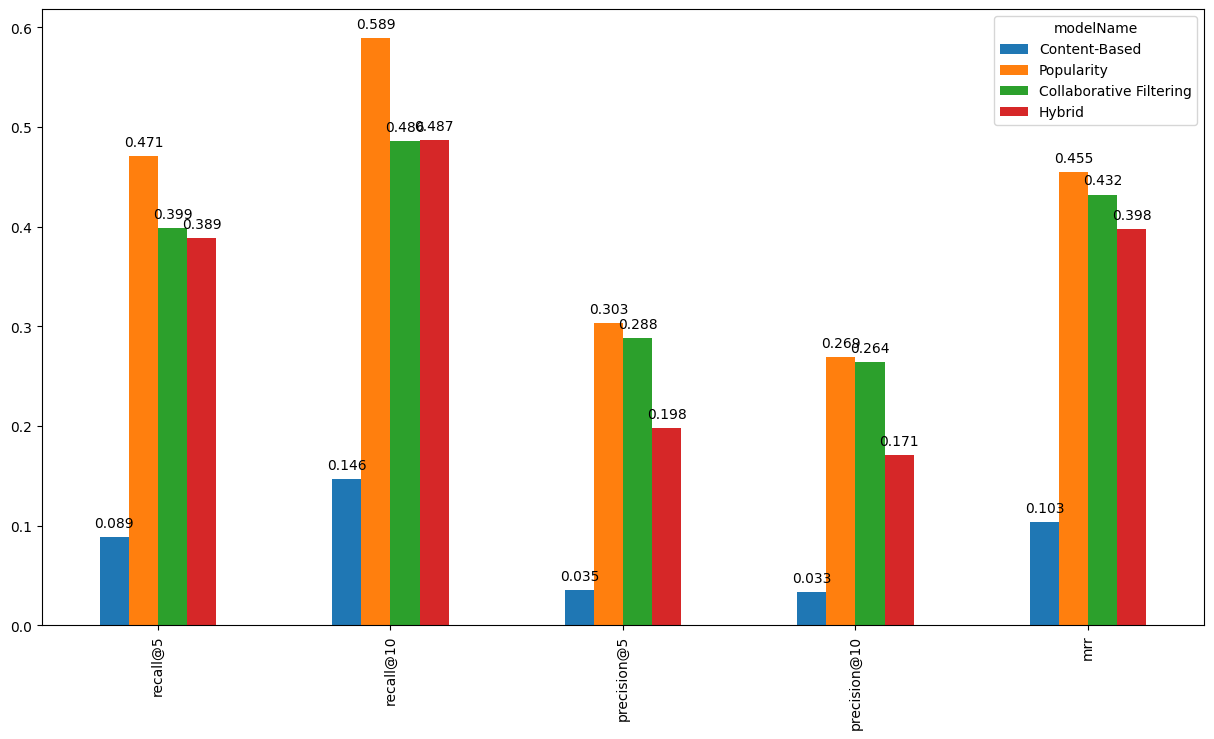

In [ ]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Reduced data weighted hybrid recommender

In [ ]:
class LowDataHybridRecommender:

    MODEL_NAME = 'LowDataHybrid'

    def __init__(self, cf_rec_model, pop_rec_model, items_df, cf_ensemble_weight=1.0, pop_ensemble_weight=1.0):
        self.cf_rec_model = cf_rec_model
        self.pop_rec_model = pop_rec_model
        self.cf_ensemble_weight = cf_ensemble_weight
        self.pop_ensemble_weight = pop_ensemble_weight
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):

        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})

        pop_recs_df = self.pop_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthPop'})

        #Combining the results by contentId
        recs_df = pop_recs_df.merge(cf_recs_df,
                                   how = 'outer',
                                   left_on = CONTENT_COLUMN_NAME,
                                   right_on = CONTENT_COLUMN_NAME).fillna(0.0)


        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrength'] = (recs_df['recStrengthCF'] * self.cf_ensemble_weight) \
                                     + (recs_df['recStrengthPop'] * self.pop_ensemble_weight)


        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrength', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')


            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = CONTENT_COLUMN_NAME,
                                                          right_on = CONTENT_COLUMN_NAME)[['recStrength', CONTENT_COLUMN_NAME, 'title']]


        return recommendations_df

lowdata_hybrid_recommender_model = LowDataHybridRecommender(cf_recommender_model, popularity_model, movie_data,
                                              cf_ensemble_weight=100.0, pop_ensemble_weight=40.0)

In [ ]:
lowdata_global_metrics, lowdata_results_dataframes = model_evaluator.evaluate_model(lowdata_hybrid_recommender_model)
model_evaluator.print_results(lowdata_global_metrics, lowdata_results_dataframes)
model_evaluator.save_results(lowdata_global_metrics, lowdata_results_dataframes, lowdata_hybrid_recommender_model.get_model_name(), DATASET_TYPE)

Evaluating LowDataHybrid recommendation model...
609 users processed

Global metrics:
       modelName  recall@5  recall@10  precision@5  precision@10       mrr
0  LowDataHybrid  0.430507   0.498221     0.314754      0.276885  0.464694
     hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
26            367            408              1343  0.273269   0.303797   
42            366            393              1257  0.291169   0.312649   
79            371            397              1052  0.352662   0.377376   
39            275            349              1043  0.263663   0.334612   
13            362            409               974  0.371663   0.419918   
3             205            237               936  0.219017   0.253205   
64            253            284               901  0.280799   0.315205   
23            333            373               859  0.387660   0.434226   
11            141            172               809  0.174289   0.212608   
73            

# Switching hybrid recommender

In [ ]:
class SwitchingHybridRecommender:

    MODEL_NAME = 'SwitchingHybrid'

    def __init__(self, cf_rec_model, pop_rec_model, hybrid_model, interactions_df, items_df):
        self.interactions_df: pd.DataFrame = interactions_df
        self.cf_rec_model = cf_rec_model
        self.pop_rec_model = pop_rec_model
        self.hybrid_model = hybrid_model
        self.items_df: pd.DataFrame = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def get_model_for_user(self, user_id):
        num_interactions = len(self.interactions_df.loc[user_id].index)
        if num_interactions <= 1:
            return self.pop_rec_model
        elif num_interactions < 4:
            return self.hybrid_model
        else:
            return self.cf_rec_model



    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        chosen_model = self.get_model_for_user(user_id)
        recs_df = chosen_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                          topn=1000)

        print(chosen_model)
        print(recs_df.head())

        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrength', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            cols_to_use = self.items_df.columns.difference(recommendations_df.columns).append(pd.Index(['movieId'])) # to avoid column clash

            recommendations_df = recommendations_df.merge(self.items_df[cols_to_use], how = 'left',
                                                          left_on = CONTENT_COLUMN_NAME,
                                                          right_on = CONTENT_COLUMN_NAME)[['recStrength', CONTENT_COLUMN_NAME, 'title']]


        return recommendations_df

switching_hybrid_recommender_model = SwitchingHybridRecommender(cf_recommender_model, popularity_model, lowdata_hybrid_recommender_model,
                                                      interactions_train_df_indexed, movie_data)

In [ ]:
switching_global_metrics, switching_results_dataframes = model_evaluator.evaluate_model(switching_hybrid_recommender_model)
model_evaluator.print_results(switching_global_metrics, switching_results_dataframes)
model_evaluator.save_results(switching_global_metrics, switching_results_dataframes, switching_hybrid_recommender_model.get_model_name(), DATASET_TYPE)

Streaming output truncated to the last 5000 lines.
3    58.986561     2571                Matrix, The
4    57.285773      110                 Braveheart
   recStrength  movieId                                              title
0    51.556630      527                                   Schindler's List
1    51.314289     2959                                         Fight Club
2    49.559890     2858                                    American Beauty
3    49.552704       50                                Usual Suspects, The
4    49.062674     1198  Raiders of the Lost Ark (Indiana Jones and the...
   recStrength  movieId                                           title
0    55.245592      260              Star Wars: Episode IV - A New Hope
1    53.690638      480                                   Jurassic Park
2    51.968061      589                      Terminator 2: Judgment Day
3    50.921406        1                                       Toy Story
4    50.429835     1196  Star Wars: E

# Comparison (with switching model)



In [ ]:
global_metrics_df = pd.concat([cb5_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics, switching_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10,precision@5,precision@10,mrr
modelName,,,,,
Content-Based,0.088721,0.146311,0.035082,0.032951,0.103217
Popularity,0.470922,0.588964,0.302951,0.268852,0.455161
Collaborative Filtering,0.399149,0.486254,0.287869,0.264098,0.432316
Hybrid,0.388831,0.486625,0.198033,0.170656,0.397985
SwitchingHybrid,0.427208,0.496070,0.316066,0.280000,0.468787


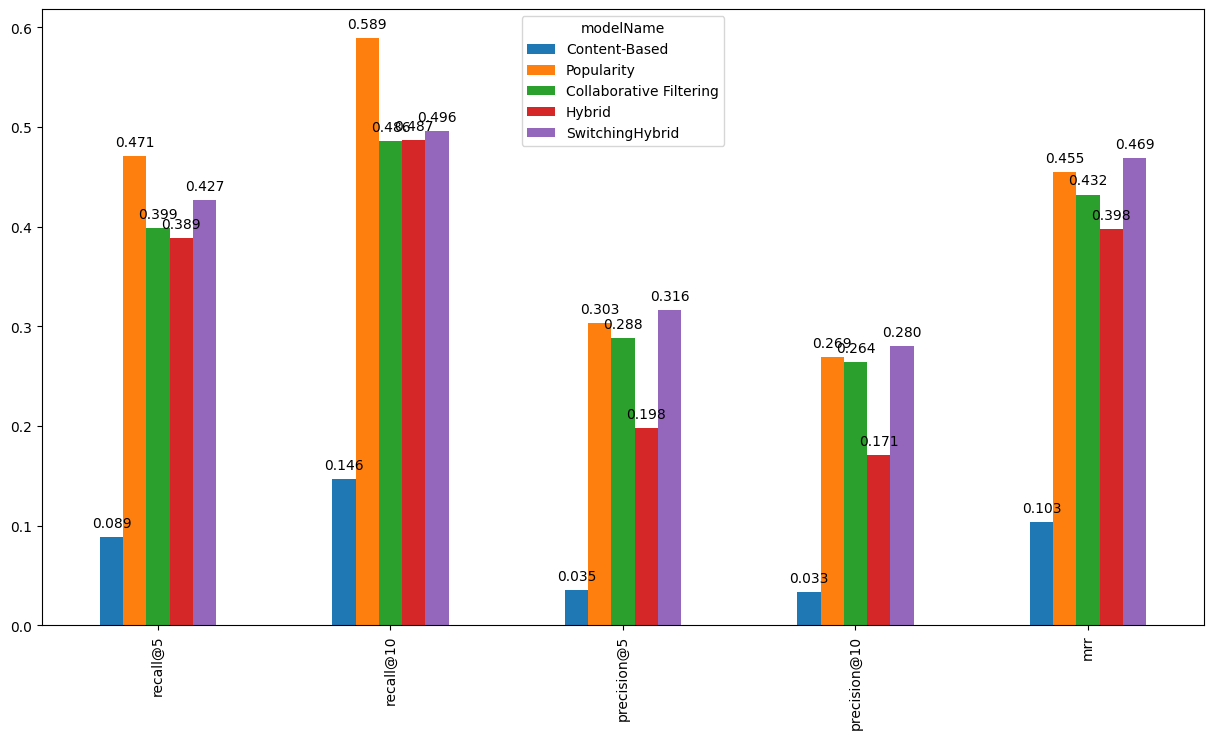

In [ ]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')